# Mini-Project 1: Quantum Calculator

 This notebook showcases the function QCalc, which takes in a positive integer d and outputs a quantum circuit where

$$QCalc|x\rangle_d|y\rangle_d |z\rangle_1|0\rangle_d =
\begin{cases}
|x\rangle_d|y\rangle_d |z\rangle_1|x+y \mod 2^d\rangle_d & \text{if } z=0 \\
|x\rangle_d|y\rangle_d |z\rangle_1|xy \mod 2^d\rangle_d & \text{if } z=1
\end{cases}$$

In this next cell, I define the function QCalc which satisfies the requirements above and the allowed gates, together with the other necessary functions,including the adder and multiplier:

In [1]:
%pip install qiskit qiskit_aer pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 11.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=7cef2811af7f8516c437c40fea26f24d6c71514f58cd8fb8ac3061d269817556
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [6]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector
import numpy as np

def cp_gate(qc,phi, control, target):
    # Apply P(ϕ/2) to target
    qc.p(phi/2, target)
    # Apply CNOT (control -> target)
    qc.cx(control, target)
    # Apply P(-ϕ/2) to target
    qc.p(-phi/2, target)
    # Apply CNOT again (control -> target)
    qc.cx(control, target)
    # Apply P(ϕ/2) to control (critical for correct phase!)
    qc.p(phi/2, control)



def qft(qc, qubits):
    n = len(qubits)
    for i in reversed(range(n)):
        qc.h(qubits[i])
        for j in reversed(range(i)):
            angle = np.pi/(2**(i-j))
            cp_gate(qc, angle, qubits[j], qubits[i])

def iqft(qc, qubits):
    n = len(qubits)
    for i in range(n):
        for j in range(i):
            angle = -np.pi/(2**(i-j))
            cp_gate(qc, angle, qubits[j], qubits[i])

        qc.h(qubits[i])
        qc.p(np.pi/2,qubits[i])


def controlled_adder(qc, d, a, b, z, ancilla):
    # QFT on target register
    qft(qc, b)

    qc.barrier()

    # Perform controlled addition
    for i in reversed(range(d)):
        for j in reversed(range(i+1)):
            angle = np.pi/(2**(i-j))
            # Implement controlled phase operation (when z=0)
            qc.x(z)
            qc.ccx(z, a[j], ancilla)
            cp_gate(qc, angle, ancilla, b[i])
            qc.p(-angle/2, ancilla)
            qc.ccx(z, a[j], ancilla)
            qc.x(z)
    qc.barrier()
    # IQFT on target register
    iqft(qc, b)


def controlled_multiplier(qc,d,x,y,z,result):
    ancilla_1 = AncillaRegister(d, 'anc_1')
    ancilla_2 = AncillaRegister(1, 'anc_2')
    qc.add_register(ancilla_1)
    qc.add_register(ancilla_2)

    # Initialize result to 0 (for addition, y gets copied over but we do not want that during multiplication)
    for i in range(d):
        qc.cx(y[i], result[i])

    qft(qc, result)

    qc.barrier()

    for i in range(d):
        qc.ccx(z,y[i],ancilla_1[0])

        for j in range(d):
            qc.ccx(x[j],ancilla_2[0],ancilla_1[j])

        for j in range(d): #shift and add multiplication
            for k in range(d):
                if j+k<d:
                    angle=np.pi/(2**k)
                    cp_gate(qc,angle,ancilla_1[j],result[j+k])

        for j in reversed(range(d)):
            qc.ccx(x[j],ancilla_2[0],ancilla_1[j])

        qc.ccx(z,y[i],ancilla_1[0])

    qc.barrier()

    iqft(qc,result)



def Qcalc(d):
    # Create registers
    x = QuantumRegister(d, 'x')
    y = QuantumRegister(d, 'y')
    z = QuantumRegister(1, 'z')
    result = QuantumRegister(d, 'result')
    ancilla = AncillaRegister(1, 'ancilla')  # Only need 1 ancilla

    qc = QuantumCircuit(result,z,y,x, ancilla)

    # Copy y to result (initial value for addition)
    for i in range(d):
        qc.cx(y[i], result[i])
    qc.barrier()


    # Implement controlled operations based on z
    controlled_adder(qc, d, x, result,z,ancilla[0])


    qc.barrier()



    # Implement controlled multiplication
    controlled_multiplier(qc,d,x,y,z,result)
    qc.barrier()

    return qc

This next block of code will output the circuit diagram based on the chosen value of d.

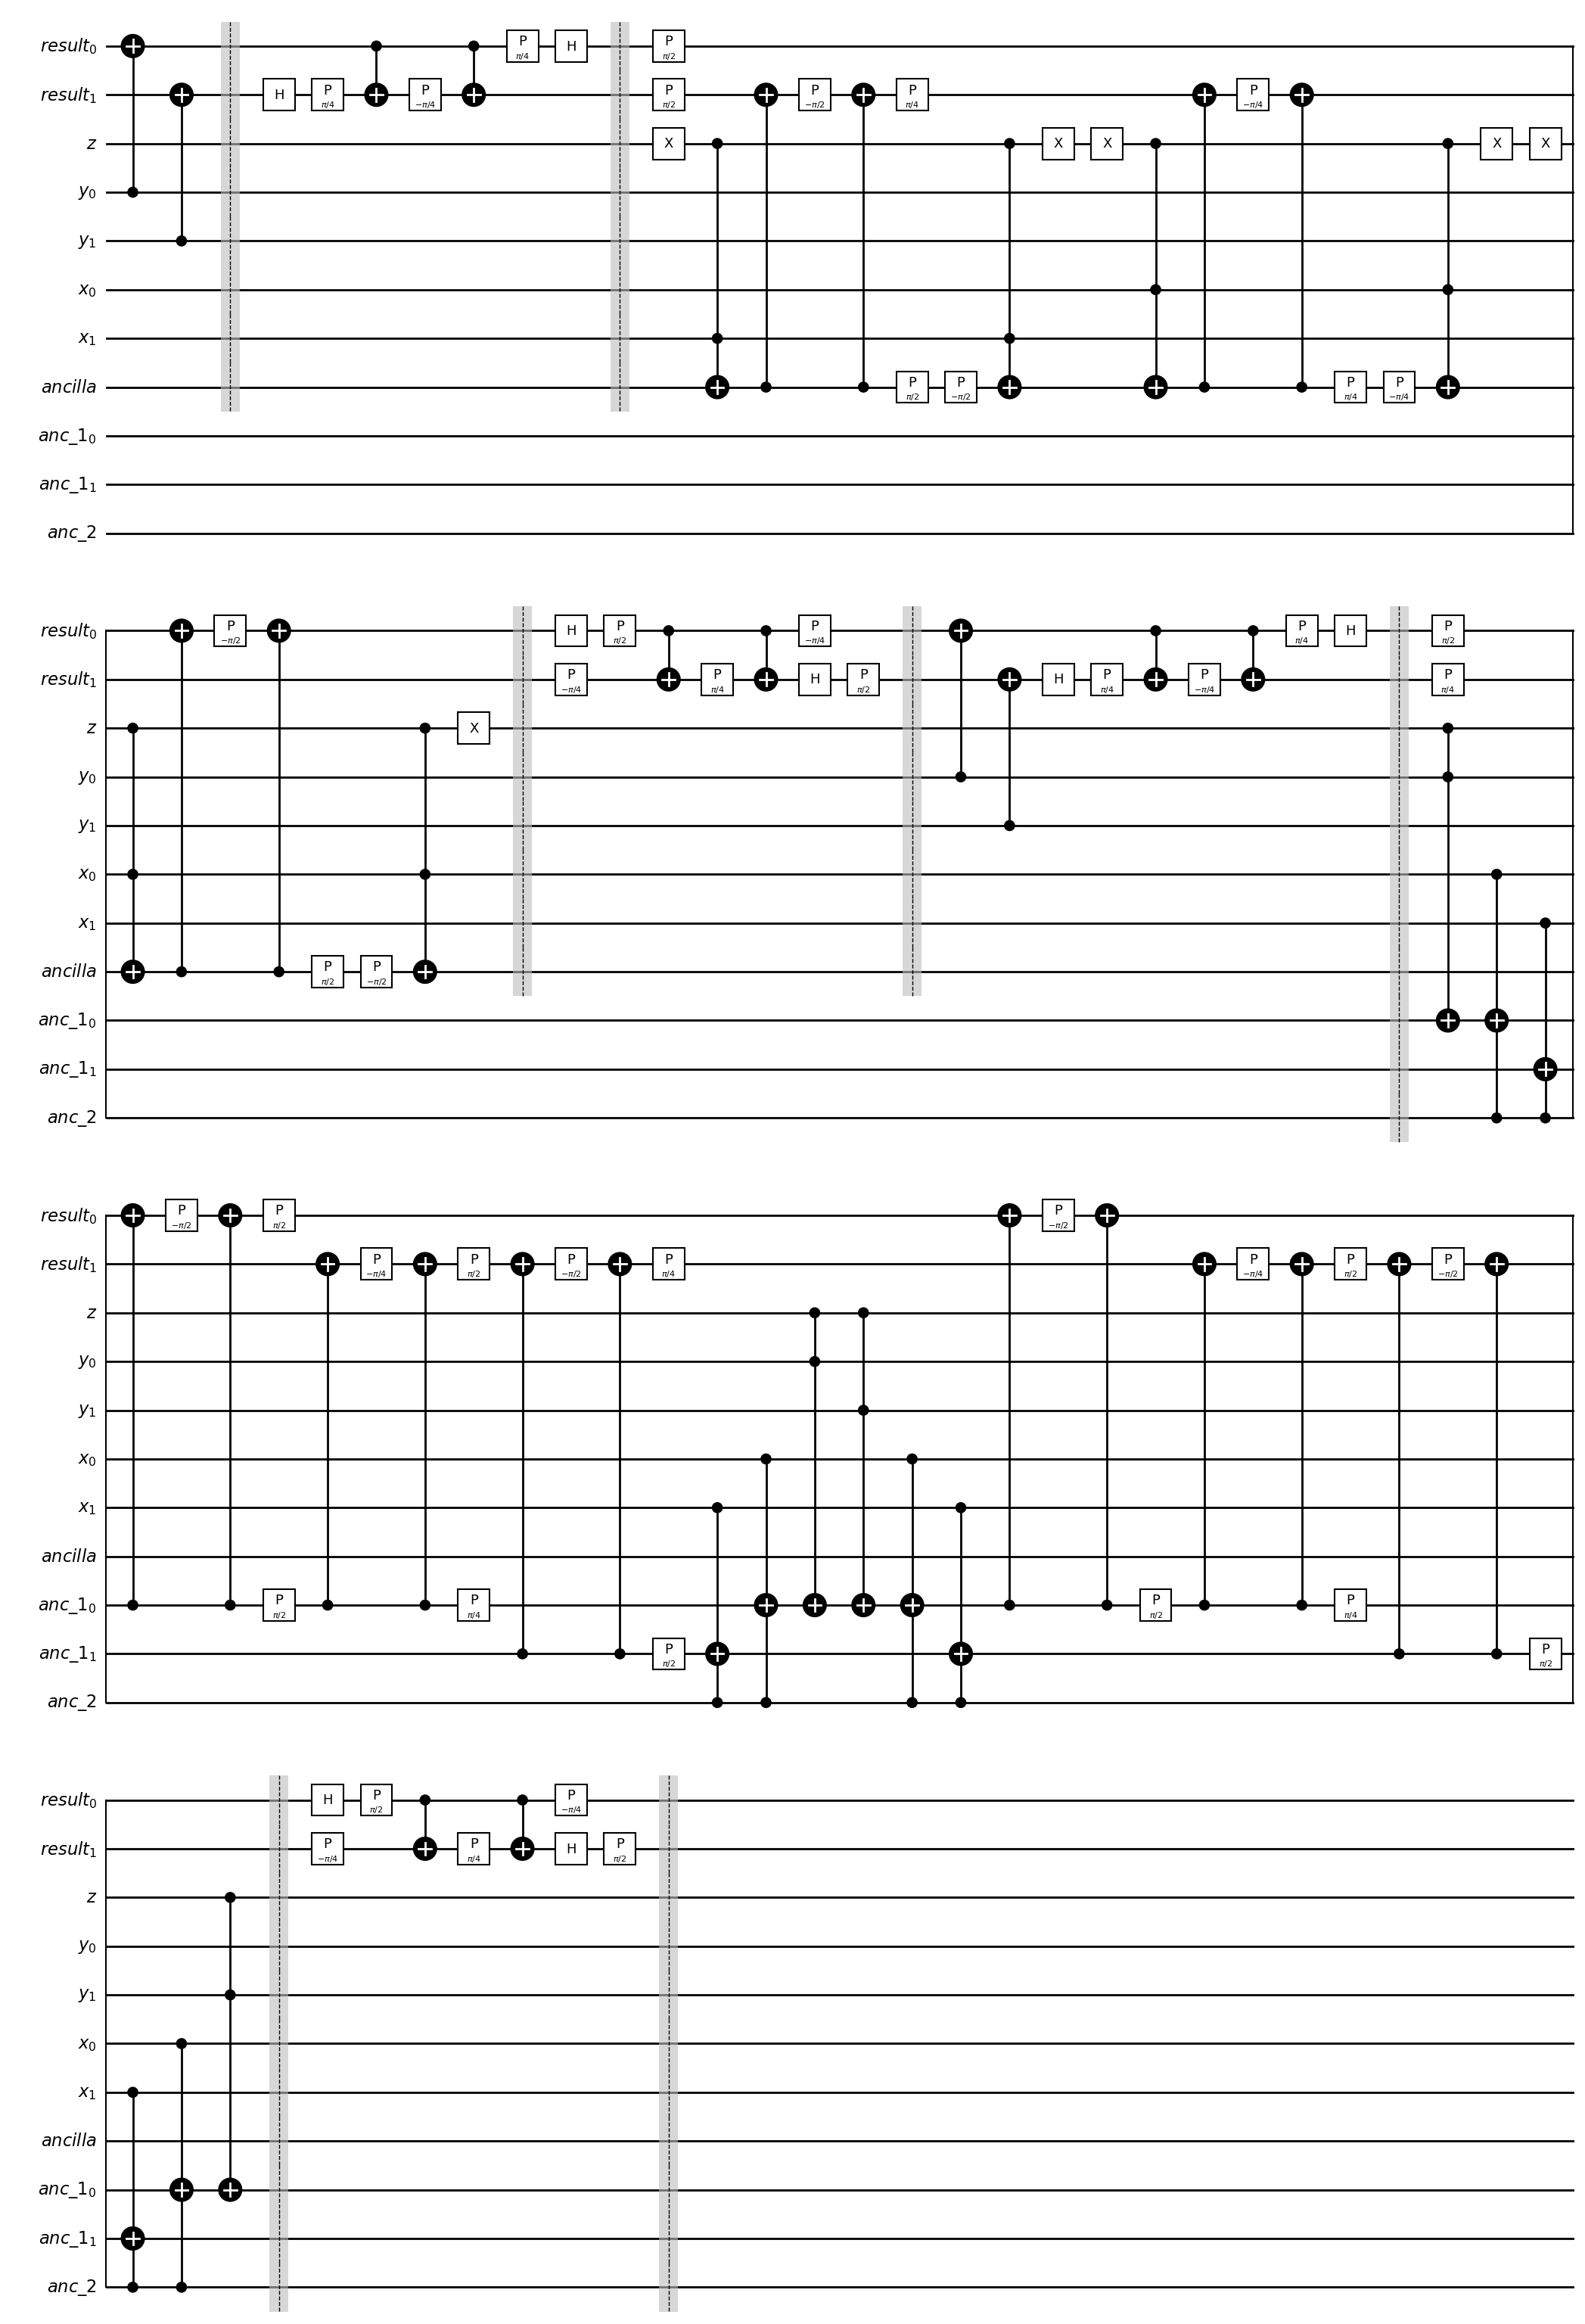

In [13]:
d = 2
qc = Qcalc(d)
qc.draw(output="mpl", style="bw", fold=30)

This next blocks of code outputs the number of gates used, the gate depth, and the number of qubits used.

In [9]:
#number of gates
qc.count_ops()

OrderedDict([('p', 46),
             ('cx', 30),
             ('ccx', 18),
             ('h', 8),
             ('barrier', 7),
             ('x', 6)])

In [10]:
#gate depth
qc.depth()

91

In [11]:
#number of qubits
qc.num_qubits

11

Now let us test the multiplication, with x=2 and y=1.

In [31]:
def test_multiplication(d=2):
    x = QuantumRegister(d, 'x')
    y = QuantumRegister(d, 'y')
    z = QuantumRegister(1, 'z')
    result = QuantumRegister(d, 'result')
    ancilla_1 = AncillaRegister(d, 'anc_3')
    ancilla_2 = AncillaRegister(1, 'anc_4')

    qc = QuantumCircuit(result, z, y, x, ancilla_1, ancilla_2)

    # x = 2 (10)
    #qc.x(x[1])
    qc.x(x[0])

    # y = 1 (01)
    qc.x(y[1])
    #qc.x(y[0])
    # z = 1 (multiplication mode)
    qc.x(z)

    for i in range(d):
        qc.cx(y[i], result[i])

    qc.barrier()

    controlled_multiplier(qc, d, x, y, z, result)

    return qc


qc = test_multiplication(2)
sv = Statevector(qc)
print("Final statevector:")
sv.draw('latex')

Final statevector:


<IPython.core.display.Latex object>

Now let us test the addition, with x=2 and y=1.

In [15]:
def test_addition(d=2):
    x = QuantumRegister(d, 'x')
    y = QuantumRegister(d, 'y')
    z = QuantumRegister(1, 'z')
    result = QuantumRegister(d, 'result')
    ancilla_1 = AncillaRegister(d, 'anc_3')
    ancilla_2 = AncillaRegister(1, 'anc_4')

    qc = QuantumCircuit(result, z, y, x, ancilla_1, ancilla_2)

    # x = 2 (10)
    qc.x(x[1])
    # y = 1 (01)
    qc.x(y[0])
    # z = 0 (addition mode)

    for i in range(d):
        qc.cx(y[i], result[i])

    qc.barrier()

    controlled_adder(qc, d, x, result, z, ancilla_2[0])

    return qc


qc = test_addition(2)
sv = Statevector(qc)
print("Final statevector:")
sv.draw('latex')

Final statevector:


<IPython.core.display.Latex object>

All the citations are in the References.md file